In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from datetime import timedelta
import time
import math
import sys
import cv2
import os
import random
import glob

In [2]:
tf.__version__

'1.2.1'

In [3]:
sys.version

'3.6.0 |Anaconda 4.3.0 (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]'

In [4]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 32 of these filters.

# Convolutional Layer 2.
filter_size2 = 3          # Convolution filters are 3 x 3 pixels.
num_filters2 = 16         # There are 16 of these filters.

# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 3 x 3 pixels.
num_filters3 = 16         # There are 16 of these filters.

# Fully-connected layer.
fc_size_1 = 512             # Number of neurons in fully-connected layer.

fc_size_2 = 128             # Number of neurons in fully-connected layer.

In [5]:
# Number of colour channels for the images: 4 channel for RGB and Transparent .
num_channels = 4

# We know that Satellite images are 640 pixels in each dimension.
img_size = 640

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)
img_shape_wChnls = (img_size, img_size, num_channels)

# class info
classes = ['vegetation', 'notVegetation']
# Number of classes, one class for each of 2 digits like Green and NotGreen.
num_classes = len(classes)

dropout_rate = 0.25

In [6]:
num_classes

2

# Pre-processing Data

## Convert Images to Array and group by dataset

identify feature of images , labels etc.  

In [7]:
class DataSet(object):

    def __init__(self, images, labels, ids, cls):
        """Construct a DataSet. one_hot arg is used only if fake_data is true."""

        self._num_examples = images.shape[0]


        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        # Convert from [0, 255] -> [0.0, 1.0].

        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)

        self._images = images
        self._labels = labels
        self._ids = ids
        self._cls = cls
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def ids(self):
        return self._ids

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:

            self._epochs_completed += 1

            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._ids[start:end], self._cls[start:end]

load images from path directory

In [8]:
def load_and_split_data(train_path, image_size, classes):
    images = []
    labels = []
    ids = []
    cls = []

    print('Reading training images')
    for fld in classes:   # assuming data directory has a separate folder for each class, and that each folder is named after the class
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            #image = cv2.imread(fl)                         # 3-channal
            image = cv2.imread(fl, cv2.IMREAD_UNCHANGED)    # 4-channal
            image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
            image = image.reshape(img_size_flat)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            ids.append(flbase)
            cls.append(fld)
    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)

    return images, labels, ids, cls

read image and split to train , validate and test set 

In [9]:
def read_train_sets(train_path, image_size, classes, validation_size=0):
    class DataSets(object):
        pass
    data_sets = DataSets()

    images, labels, ids, cls = load_and_split_data(train_path, image_size, classes)
    
    index_vegetation, = np.where(cls == classes[0] )
    index_notvegetation, = np.where(cls == classes[1] )
    
    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])
        
    balance_size = int( (len(images) - validation_size) / num_classes )
    index_random_vegetation = random.sample(list(index_vegetation), balance_size)
    index_random_notVegetation = random.sample(list(index_notvegetation), balance_size)
    index_random_balance = index_random_vegetation + index_random_notVegetation
    
    train_images = images[index_random_balance]
    train_labels  = labels[index_random_balance]
    train_ids  = ids[index_random_balance]
    train_cls  = cls[index_random_balance]
    
    validation_cls = np.delete(cls, index_random_balance)
    validation_ids = np.delete(ids, index_random_balance)
    validation_labels = np.delete(labels, index_random_balance, axis=0)
    validation_images = np.delete(images, index_random_balance, axis=0)   
    
    train_images, train_labels, train_ids, train_cls = shuffle(train_images, 
                                                               train_labels, 
                                                               train_ids, 
                                                               train_cls)  # shuffle the data
    validation_images, validation_labels, validation_ids, validation_cls = shuffle(validation_images, 
                                                                                   validation_labels, 
                                                                                   validation_ids, 
                                                                                   validation_cls)  # shuffle the data

    data_sets.train = DataSet(train_images, train_labels, train_ids, train_cls)
    data_sets.valid = DataSet(validation_images, validation_labels, validation_ids, validation_cls)

    return data_sets

def read_test_set(test_path, image_size, classes):
    class DataSets(object):
        pass
    datatest = DataSets()
    
    test_images, test_labels , test_ids , test_cls  = load_and_split_data(test_path, image_size, classes)
    
    datatest = DataSet(test_images, test_labels, test_ids, test_cls)
    
    return datatest

## Load Image and convert to Array

In [10]:
# validation split
validation_size = .30

train_path = 'D:\FaamruProject_kor\Dataset\FaamruDS\_training'
test_path = 'D:\FaamruProject_kor\Dataset\FaamruDS\_testing'

In [11]:
data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)

Reading training images
Loading vegetation files (Index: 0)
Loading notVegetation files (Index: 1)


In [12]:
datatest = read_test_set(test_path, img_size, classes)

Reading training images
Loading vegetation files (Index: 0)
Loading notVegetation files (Index: 1)


In [13]:
print("Size of Dataset :")
print("- Training-set\t\t: {}".format(len(data.train.labels)))
print("- Validation-set\t: {}".format(len(data.valid.labels)))
print("- Test-set(Unseen Data)\t: {}".format(len(datatest.images)))

Size of Dataset :
- Training-set		: 1834
- Validation-set	: 785
- Test-set(Unseen Data)	: 655


In [14]:
data.train.images.shape

(1834, 1638400)

In [15]:
len(data.train.images[5])

1638400

In [16]:
len(datatest.images[5])

1638400

In [17]:
images = data.train.images
print('images[1]\t\t: ',images[1])
print('type of images[1]\t: ',type(images[1]))
print('shape of images[1]\t: ',images.shape)
print('len of images[1]\t: ',len(images[1]))

images[1]		:  [ 1.  1.  1. ...,  1.  1.  0.]
type of images[1]	:  <class 'numpy.ndarray'>
shape of images[1]	:  (1834, 1638400)
len of images[1]	:  1638400


In [18]:
data.train.cls

array(['notVegetation', 'vegetation', 'notVegetation', ...,
       'notVegetation', 'notVegetation', 'notVegetation'], 
      dtype='<U13')

In [19]:
vegetationT = sum(i == 'vegetation' for i in data.train.cls)
NotvegetationT = sum(i == 'notVegetation' for i in data.train.cls)
vegetationV = sum(i == 'vegetation' for i in data.valid.cls)
NotvegetationV = sum(i == 'notVegetation' for i in data.valid.cls)

In [20]:
print('train -> vegetation : ',vegetationT)
print('train -> notVegetation : ',NotvegetationT)
print('validate -> vegetation : ',vegetationV)
print('validate -> notVegetation : ',NotvegetationV)

train -> vegetation :  917
train -> notVegetation :  917
validate -> vegetation :  255
validate -> notVegetation :  530


# Plotting Images

In [21]:
def index_random(data ,size):
    data_range = range(len(data))
    
    return random.sample(data_range, size)

In [22]:
### Plotting image by array data
def plot_img_new(images, cls_true , ids , cls_pred=None):  
    
    #features = data_arr[0]            # images
    #lables = data_arr[1]              # cls_true
    #images_filename = data_arr[2]     # ids 
    
    
    
    if len(images) <16 :
        indexs_random = range(len(images))
    else :
        indexs_random = index_random(images, 16)
        assert len(indexs_random) == 16
        
    fig, axes = plt.subplots(4, 4 ,figsize=(12,12))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)
    
    for i, ax in enumerate(axes.flat):
                
        # Read PNG Image from Directory 
        feature_img = images[ indexs_random[i] ]
        
        # Plot image.
        ax.imshow(cv2.cvtColor(feature_img.reshape(img_shape_wChnls), cv2.COLOR_BGR2RGB), interpolation = 'bicubic' )
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])  # to hide tick values on X and Y axis
        
        # Show the Title of images.
        ax.set_title('Pic : {0}'.format( ids[indexs_random[i]] ))
        
        #Show True and Predicted classes
        if cls_pred is None:
            xlabel = 'True : {0}'.format( cls_true[indexs_random[i]] )
        else:
            xlabel = 'True : {0}, \nPred : {1}'.format( cls_true[indexs_random[i]] , cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        
        
    plt.show()


		*** Training Data : Sampling 16 images of 1834 images *** 


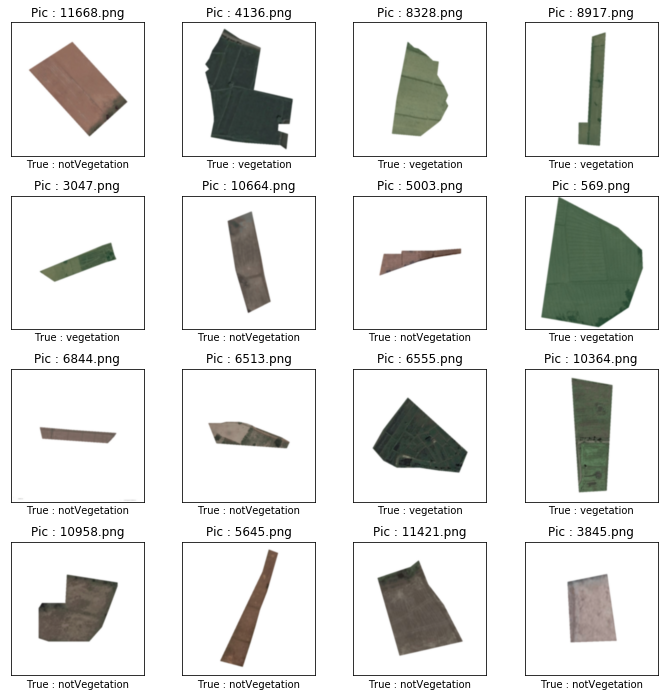

In [23]:
print('')
print('\t\t*** Training Data : Sampling 16 images of {} images *** '.format(len(data.train.images)))

# Get the first images from the trainning-set.
images_train = data.train.images

# Get the true classes for those images.
cls_true_train = data.train.cls

# Get the file names for those images.
ids_filename_train = data.train.ids

# Plot the images and labels using our helper-function above.
plot_img_new(images=images_train, cls_true=cls_true_train , ids=ids_filename_train)


		*** Validation Data : Sampling 16 images of 785 images *** 


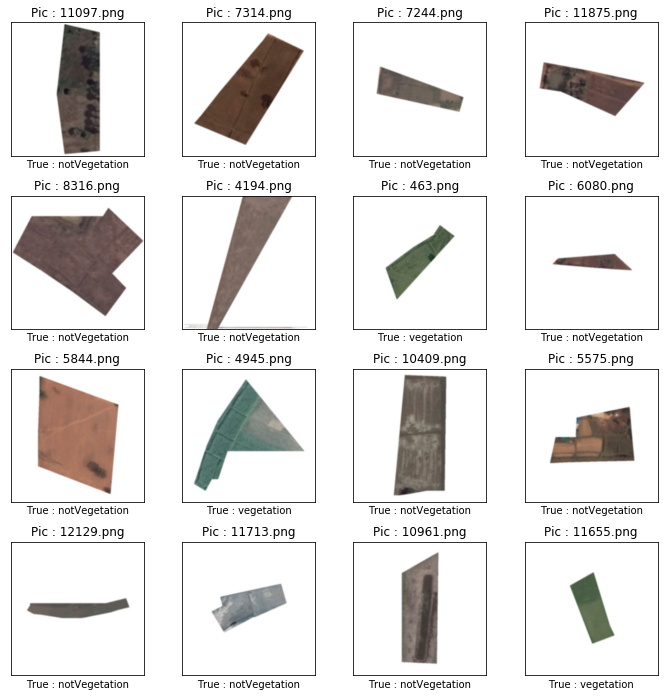

In [24]:
print('')
print('\t\t*** Validation Data : Sampling 16 images of {} images *** '.format(len(data.valid.images)))

# Get the first images from the validate-set.
images_validate = data.valid.images

# Get the true classes for those images.
cls_true_validate = data.valid.cls

# Get the file names for those images.
ids_filename_validate = data.valid.ids

plot_img_new(images=images_validate, cls_true=cls_true_validate , ids=ids_filename_validate)

# TensorFlow Graph

create component in model by my designing

# Creating New Variables

In [25]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [26]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

# Creating a Convolutional Layer

In [27]:
def conv_layer(input,         # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    return layer, weights

# Creating a Full-Connected Layer

In [28]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [29]:
def dropout_layer(input,dropout_rate,traning_mode):
    features = input
    dropout_layer = tf.layers.dropout(features,rate=dropout_rate,training=traning_mode)
    
    return dropout_layer

In [30]:
def fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables

In [31]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x') #img_size_flat 640 x 640 

In [32]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [33]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [34]:
y_true_cls = tf.argmax(y_true, axis=1)

### Convolutional Layer 1

In [35]:
layer_conv1, weights_conv1 = conv_layer(input=x_image,  #image_dataset
                   num_input_channels=num_channels,     #number_channal=4
                   filter_size=filter_size1,            #filter_size = 5 x 5
                   num_filters=num_filters1,            #number_filter = 32
                   use_pooling=True)                    #max_pooling = 2x2 , stride = 2 step 

In [36]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 320, 320, 32) dtype=float32>

### Convolutional Layer 2

In [37]:
layer_conv2, weights_conv2 = conv_layer(input=layer_conv1,  #image_dataset
                   num_input_channels=num_filters1,         #number_channal is num_filter 0f conv. layer 1 = 32 
                   filter_size=filter_size2,                #filter_size = 3 x 3
                   num_filters=num_filters2,                #number_filter = 16
                   use_pooling=True)                        #max_pooling = 2x2 , stride = 2 step 

In [38]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 160, 160, 16) dtype=float32>

### Convolutional Layer 3

In [39]:
layer_conv3, weights_conv3 = conv_layer(input=layer_conv2,  #image_dataset
                   num_input_channels=num_filters2,         #number_channal is num_filter 0f conv. layer 1 = 32 
                   filter_size=filter_size3,                #filter_size = 3 x 3
                   num_filters=num_filters3,                #number_filter = 16
                   use_pooling=True)                        #max_pooling = 2x2 , stride = 2 step 

In [40]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 80, 80, 16) dtype=float32>

### Flatten Layer 1

In [41]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [42]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 102400) dtype=float32>

In [43]:
num_features

102400

### Full-Connected Layer 1

In [44]:
layer_fc1 = fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size_1,          #fc_size =  512
                         use_relu=True)

In [45]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 512) dtype=float32>

### Dropout Layer 1

In [46]:
layer_dropout1 = dropout_layer(input=layer_fc1,
                         dropout_rate=dropout_rate,
                         traning_mode=True)

In [47]:
layer_dropout1

<tf.Tensor 'dropout/dropout/mul:0' shape=(?, 512) dtype=float32>

### Full-Connected Layer 2

In [48]:
layer_fc2 = fc_layer(input=layer_dropout1,
                         num_inputs=fc_size_1,
                         num_outputs=fc_size_2,          #fc_size = 128 
                         use_relu=True)

In [49]:
layer_fc2

<tf.Tensor 'Relu_4:0' shape=(?, 128) dtype=float32>

### Dropout Layer 2

In [50]:
layer_dropout2 = dropout_layer(input=layer_fc2,
                         dropout_rate=dropout_rate,
                         traning_mode=True)

In [51]:
layer_dropout2

<tf.Tensor 'dropout_2/dropout/mul:0' shape=(?, 128) dtype=float32>

### Full-Connected Layer 3

In [52]:
layer_fc3 = fc_layer(input=layer_dropout2,
                         num_inputs=fc_size_2,
                         num_outputs=num_classes,          #fc_size = 2 class _ output
                         use_relu=False)

In [53]:
layer_fc3

<tf.Tensor 'add_5:0' shape=(?, 2) dtype=float32>

# Predicted Class

Generate Predictions

In [54]:
y_pred = tf.nn.softmax(layer_fc3)  #probabilities

In [55]:
y_pred_cls = tf.argmax(y_pred, axis=1)    #classes

# Cost-function to be optimized

In [56]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3,
                                                        labels=y_true)

In [57]:
cost = tf.reduce_mean(cross_entropy)

# Optimization Method

In [58]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost) #'learning_rate': 0.0001

# Performance Measures

this section is create values to confusion matrix

In [59]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [60]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In [61]:
saver = tf.train.Saver()

In [62]:
save_dir = 'D:\FaamruProject_kor\Model\checkpoints\_3274'

In [63]:
date_create = "{}".format(time.strftime('%Y%m%d', time.localtime(time.time())))

In [64]:
save_dir_date = os.path.join(save_dir, date_create)
if not os.path.exists(save_dir_date):
    os.makedirs(save_dir_date)

In [65]:
name_directory_best_validation = 'best_validate_3274_basicCNN_i300'

In [66]:
name_directory_best_validation

'best_validate_3274_basicCNN_i300'

In [67]:
save_path = os.path.join(save_dir_date, name_directory_best_validation)

In [68]:
save_path

'D:\\FaamruProject_kor\\Model\\checkpoints\\_3274\\20180508\\best_validate_3274_basicCNN_i300'

# TensorFlow Run

In [69]:
#Create TensorFlow session

session = tf.Session()

#Initialize variables

session.run(tf.global_variables_initializer())

function to perform optimization iterations

In [70]:
train_batch_size = 128

In [71]:
validate_batch_size = 64

In [72]:
# Best validation accuracy seen so far.
best_validation_loss = 1.5

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 5000

In [73]:
def print_progress(optimize_iterations, epoch, feed_dict_train, feed_dict_validate, val_loss , improved_str):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Optimize_iterations : {0}\tEpoch {1} --- Training Accuracy: {2:>6.3%}, Validation Accuracy: {3:>6.3%}, Validation Loss: {4:.3f} {5}"
    print(msg.format(optimize_iterations,epoch, acc, val_acc, val_loss , improved_str))

In [74]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def train_optimize(num_iterations , continue_iterate=False):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    global best_validation_loss         #20180329
    global last_improvement             #20180329
    global patience
    global require_improvement
    
    number_batch_epoch = 0

    # Start-time used for printing time-usage below.
    start_time = time.time()
    print("Start Time : " + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))  

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(validate_batch_size)

        # Put the batch into a dict with the proper names
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        
        #if i % int(data.train.num_examples/train_batch_size) == 0: 
        val_loss = session.run(cost, feed_dict=feed_dict_validate)
        if number_batch_epoch < int(data.train.num_examples/train_batch_size):
                number_batch_epoch += 1
        else:
                number_batch_epoch = 0
        optimize_iterations = i+1

        if require_improvement:    
            if val_loss < best_validation_loss:
                best_validation_loss = val_loss
                last_improvement = 0
                saver.save(sess=session, save_path=save_path)
                improved_str = '*'
            else:
                last_improvement += 1
                improved_str = ''

            if last_improvement == require_improvement:
                break
        
        print_progress(optimize_iterations,number_batch_epoch, feed_dict_train, feed_dict_validate, val_loss , improved_str)

    # Update the total number of iterations performed.
    if continue_iterate:
        total_iterations += num_iterations

    # Ending time.
    end_time = time.time()
    print("End Time : " + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time)))

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

function to plot example errors

In [75]:
def plot_example_errors(cls_pred, correct):

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    ids = data.valid.ids[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]
    
       
    plot_errors_image(images=images,
                cls_true=cls_true,
                ids=ids,
                cls_pred=cls_pred)

In [76]:
def plot_errors_image(images , cls_true , ids , cls_pred):
      
    # Number of filters used in the conv. layer.
    num_filters = images.shape[0]

    # Number of grids to plot.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids,figsize=(15,15))
    fig.subplots_adjust(hspace=0.8, wspace=0.2)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = images[i]

            # Plot image.
            ax.imshow(cv2.cvtColor(img.reshape(img_shape_wChnls), cv2.COLOR_BGR2RGB), interpolation = 'bicubic' )
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
        xlabel = '{0} \nTrue : {1} \nPred : {2}'.format(ids[i] , cls_true[i] , cls_pred[i])
        ax.set_xlabel(xlabel)
        
        if i == num_filters-1 :
            break
            
            
    plt.xticks([])
    plt.yticks([])

    plt.show()

function to plot confusion matrix

In [77]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)
    
    # Print the Recall - Precision - F1 score.
    #print('Recall : ',metrics.recall_score( cls_true , cls_pred ))
    
    

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

function for showing the performance

In [78]:
def validation_performance(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.valid.images)

    cls_pred = np.zeros(shape=num_test, dtype=np.int)


    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + validate_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :]
        

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Validate-Set: {0:.3%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance after 1 optimization iteration

In [79]:
train_optimize(num_iterations=1)

Start Time : 2018-05-08 21:36:53
Optimize_iterations : 1	Epoch 1 --- Training Accuracy: 52.344%, Validation Accuracy: 70.312%, Validation Loss: 0.689 *
End Time : 2018-05-08 21:39:39
Time elapsed: 0:02:47


In [80]:
validation_performance()

Accuracy on Validate-Set: 67.516% (530 / 785)


## Performance after 300 optimization iterations

After 300 optimization iterations, the model should have significantly improved its classification accuracy.

In [81]:
train_optimize(num_iterations=300)

Start Time : 2018-05-09 10:10:49
Optimize_iterations : 1	Epoch 1 --- Training Accuracy: 54.688%, Validation Accuracy: 62.500%, Validation Loss: 0.672 *
Optimize_iterations : 2	Epoch 2 --- Training Accuracy: 51.562%, Validation Accuracy: 46.875%, Validation Loss: 0.717 
Optimize_iterations : 3	Epoch 3 --- Training Accuracy: 54.688%, Validation Accuracy: 35.938%, Validation Loss: 0.814 
Optimize_iterations : 4	Epoch 4 --- Training Accuracy: 50.000%, Validation Accuracy: 39.062%, Validation Loss: 0.795 
Optimize_iterations : 5	Epoch 5 --- Training Accuracy: 62.500%, Validation Accuracy: 35.938%, Validation Loss: 0.736 
Optimize_iterations : 6	Epoch 6 --- Training Accuracy: 48.438%, Validation Accuracy: 48.438%, Validation Loss: 0.691 
Optimize_iterations : 7	Epoch 7 --- Training Accuracy: 57.031%, Validation Accuracy: 60.938%, Validation Loss: 0.679 
Optimize_iterations : 8	Epoch 8 --- Training Accuracy: 51.562%, Validation Accuracy: 59.375%, Validation Loss: 0.652 *
Optimize_iterations :

Accuracy on Validate-Set: 87.643% (688 / 785)
Example errors:


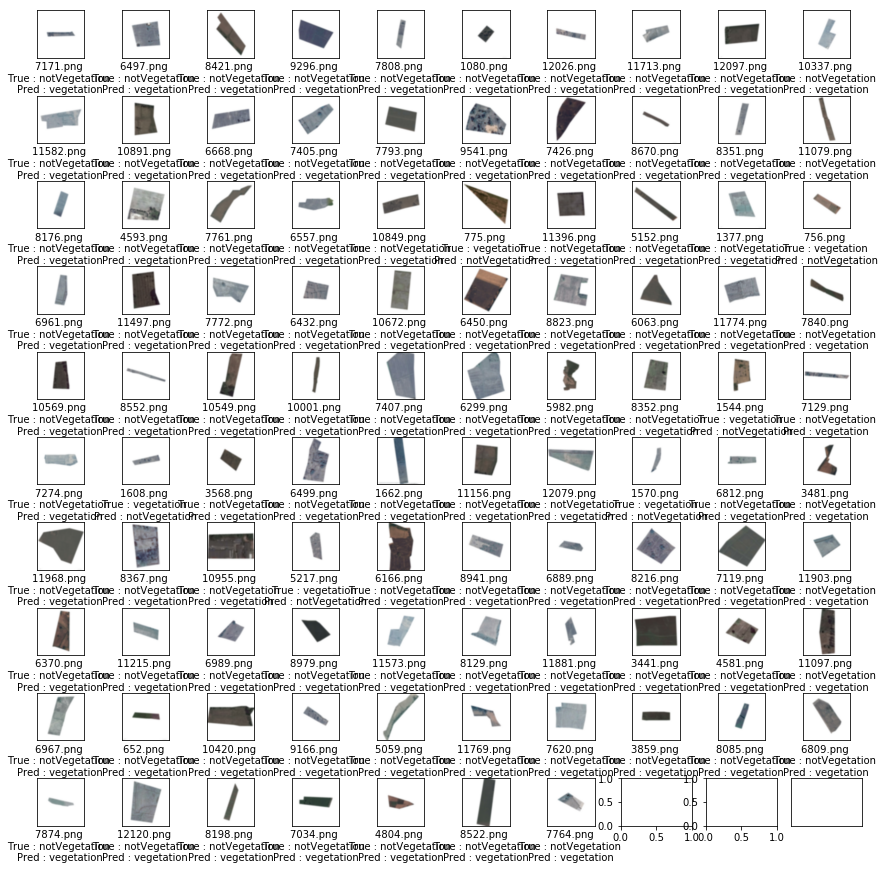

Confusion Matrix:
[[439  91]
 [  6 249]]


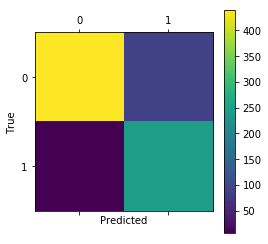

In [82]:
validation_performance(show_confusion_matrix=True , show_example_errors=True)

## Restore Best Variables

Re-load all the variables that were saved to file during optimization.

In [83]:
saver.restore(sess=session, save_path=save_path)

INFO:tensorflow:Restoring parameters from D:\FaamruProject_kor\Model\checkpoints\_3274\20180508\best_validate_3274_basicCNN_i300


Accuracy on Validate-Set: 91.975% (722 / 785)
Confusion Matrix:
[[497  33]
 [ 30 225]]


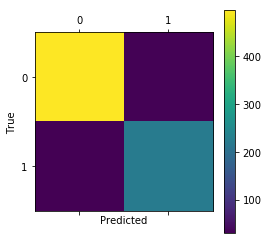

In [85]:
validation_performance(show_confusion_matrix=True , show_example_errors=False)

## Visualization of Weights and Layers


### plotting convolutional weights

In [86]:
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### plotting the output of a convolutional layer

In [87]:
def plot_conv_layer(layer, image):
   
    image = image.reshape(img_size_flat)

    # Create a feed-dict containing just one image.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Input Testing - Images

function for plotting an image.

In [88]:
def plot_image(image):
    plt.imshow(image.reshape(img_size, img_size, num_channels),
               interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

    plt.show()

Plot an image from the test-set which will be used as an example below.

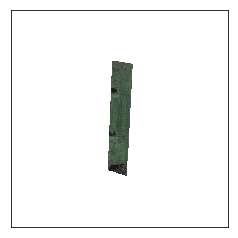

In [89]:
image1 = datatest.images[6]
plot_image(image1)

Plot another example image from the test-set.

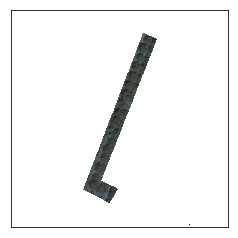

In [90]:
image2 = datatest.images[30]
plot_image(image2)

# Plot Images Output of Convolution Layer and Weight of each Layer

### Convolution Layer 1

weight of Convolution Layer 1

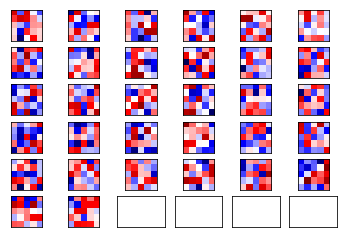

In [91]:
plot_conv_weights(weights=weights_conv1)

output of images in convolutional layer 1

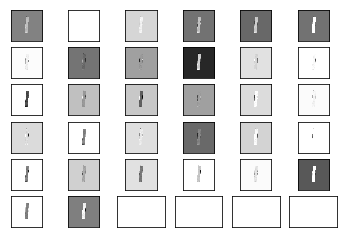

In [92]:
plot_conv_layer(layer=layer_conv1, image=image1)

### Convolution Layer 2

weight of Convolution Layer 2

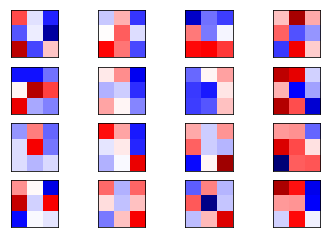

In [93]:
plot_conv_weights(weights=weights_conv2)

output of images in convolutional layer 1

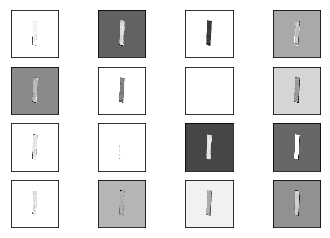

In [94]:
plot_conv_layer(layer=layer_conv2, image=image1)

### Convolution Layer 3

weight of Convolution Layer 3

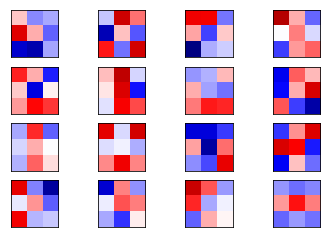

In [95]:
plot_conv_weights(weights=weights_conv3)

output of images in convolutional layer 2

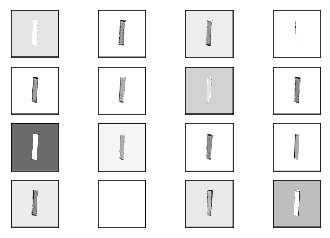

In [96]:
plot_conv_layer(layer=layer_conv3, image=image1)

### Write Test Predictions to CSV

In [97]:
def plot_test_image(image , result):
    
    result_list = result.values.T.tolist()
   
    # Number of filters used in the conv. layer.
    num_filters = result.shape[0]

    # Number of grids to plot.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids,figsize=(15,15))
    fig.subplots_adjust(hspace=0.8, wspace=0.2)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = image[i]

            # Plot image.
            ax.imshow(cv2.cvtColor(img.reshape(img_shape_wChnls), cv2.COLOR_BGR2RGB), interpolation = 'bicubic' )
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
        xlabel = '{0} \nTrue : {1} \nPred : Veg :{2}\n       notV : {3}'.format(result_list[0][i] , result_list[1][i] ,\
                                                                               result_list[2][i] , \
                                                                               result_list[3][i])
        ax.set_xlabel(xlabel)
        
        if i == num_filters-1 :
            break
            
            
    plt.xticks([])
    plt.yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [98]:
def predictions(ims, cls , ids , write_file=True , plot_testing=False):

    images_test = ims.reshape(ims.shape[0], img_size_flat)
    num_test = len(images_test)
    
    i = 0
    ims_test_pred = list()
    images_test_pred = list()
    
    saver.restore(sess=session, save_path=save_path)

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + validate_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = images_test[i:j, :]
        
        # Calculate the predicted class using TensorFlow.
        
        ims_test_pred = session.run(y_pred, feed_dict={x: images})
        images_test_pred.extend(ims_test_pred)
        
        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

        result = pd.DataFrame(images_test_pred, columns=classes)
    
    
    result['vegetation'] = pd.Series(["{0:.2f}%".format(val * 100) for val in result['vegetation']], index = result.index)
    result['notVegetation'] = pd.Series(["{0:.2f}%".format(val * 100) for val in result['notVegetation']], index = result.index)
    result.insert(loc=0, column='ids', value=ids)
    result.insert(loc=1, column='labels', value=cls)
    
    result['predicted'] = np.where(result['vegetation'] >= result['notVegetation'], 'vegetation', 'notVegetation')
    
    if plot_testing:
        plot_test_image(ims, result)
    
    pred_file = 'predictions_{}.csv'.format(time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())))
    
    if write_file:
        result.to_csv(pred_file, index=False) 
    
    result_list = result.values.T.tolist()
    result_labels = result_list[1]
    result_predicted = result_list[4]
    
    cm = confusion_matrix(y_true=result_labels,
                          y_pred=result_predicted)
    
    correct_prediction = tf.equal(result_predicted, result_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    accuracy_testimages = session.run(accuracy)

    print('===== Result of prediction Images ======')   
    print(result)

    print('===== Confusion Matrix ======')
    print(cm)
    
    print('Accuracy of Test Images : {0:.2f}%'.format(accuracy_testimages*100))

In [99]:
predictions(datatest.images, datatest.cls, datatest.ids , write_file=True , plot_testing=False)

INFO:tensorflow:Restoring parameters from D:\FaamruProject_kor\Model\checkpoints\_3274\20180508\best_validate_3274_basicCNN_i300
===== Result of prediction Images ======
           ids         labels vegetation notVegetation      predicted
0    10006.png     vegetation     98.28%         1.72%     vegetation
1    10007.png     vegetation     98.66%         1.34%     vegetation
2    10022.png     vegetation     93.83%         6.17%     vegetation
3    10160.png     vegetation     99.41%         0.59%     vegetation
4    10162.png     vegetation     96.80%         3.20%     vegetation
5    10217.png     vegetation     96.87%         3.13%     vegetation
6    10229.png     vegetation     89.05%        10.95%     vegetation
7    10268.png     vegetation     96.87%         3.13%     vegetation
8    10272.png     vegetation     92.40%         7.60%     vegetation
9    10280.png     vegetation     94.12%         5.88%     vegetation
10   10291.png     vegetation     76.77%        23.23%     v